# imports

In [1]:
# Dataset preprocessor to prepare the data for training
import numpy as np
import torch
import pickle
import os
from time import time
import scipy.io as sio
import matplotlib.pyplot as plt

from NTdatasets.generic import GenericDataset
from NTdatasets.cumming.monocular import MultiDataset
import NTdatasets.conway.cloud_datasets as datasets

import ColorDataUtils.ConwayUtils as CU
import ColorDataUtils.EyeTrackingUtils as ETutils

# NDN tools
import NDNT.utils as utils # some other utilities
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from time import time
from copy import deepcopy

import sys
sys.path.append('./lib')
import runner2 as r
import model as m
import experiment as exp
import plot

from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy

%load_ext autoreload
%autoreload 2

Invoking __init__.py for NDNT.utils


In [2]:
datadir = '/home/dbutts/ColorV1/Data/'
dirname = '/home/dbutts/ColorV1/CLRworkspace/'
fn = 'Jocamo_220715_full_CC_ETCC_nofix_v08'
#fn = 'Jocamo_220727_full_CC_ETCC_nofix_v08'
num_lags=12

# load data

In [3]:
t0 = time()
data = datasets.ColorClouds(
    datadir=datadir, filenames=[fn], eye_config=3, drift_interval=16,
    luminance_only=True, binocular=False, include_MUs=True, num_lags=num_lags,
    trial_sample=True)
t1 = time()
print(t1-t0, 'sec elapsed')

Reducing stimulus channels (3) to first dimension
Loading data into memory...
Adjusting stimulus read from disk: mean | std = -0.000 | 0.269
T-range: 0 167520
  Trimming experiment 365280->167520 time points based on eye_config and Tmax
117.39414691925049 sec elapsed


In [4]:
NT = data.robs.shape[0]
NA = data.Xdrift.shape[1]
print("%d (%d valid) time points"%(NT, len(data)))
#data.valid_inds = np.arange(NT, dtype=np.int64)

lam_units = np.where(data.channel_map < 32)[0]
ETunits = np.where(data.channel_map >= 32)[0]
UTunits = np.where(data.channel_map >= 32+127)[0]

print( "%d laminar units, %d ET units"%(len(lam_units), len(ETunits)))

# Replace DFs
matdat = sio.loadmat(datadir+'Jocamo_220715_full_CC_ETCC_nofix_v08_DFextra.mat')
data.dfs = torch.tensor( matdat['XDF'][:NT, :], dtype=torch.float32 )

# Pull correct saccades
matdat = sio.loadmat(datadir+'Jocamo_220715_full_CC_ETCC_v08_ETupdate.mat')
sac_ts_all = matdat['ALLsac_bins'][0, :]

data.process_fixations( sac_ts_all )
sac_tsB = matdat['sac_binsB'][0, :]
sac_tsL = matdat['sac_binsL'][0, :]
sac_tsR = matdat['sac_binsR'][0, :]

NFIX = torch.max(data.fix_n).detach().numpy()
print(NFIX, 'fixations')
et1kHzB = matdat['et1kHzB']
et60B = matdat['et60HzB']
et60all = matdat['et60Hz_all']

print(lam_units, 'laminar units', data.robs.shape, 'robs', data.dfs.shape, 'dfs')

167520 (167520 valid) time points
29 laminar units, 210 ET units
  Redoing fix_n with saccade inputs: 6827 saccades
3795 fixations
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14 128 129 130
 131 132 133 134 135 136 137 138 139 140 141] laminar units torch.Size([167520, 239]) robs torch.Size([167520, 239]) dfs


21 out of 29 units used
Output set to 21 cells


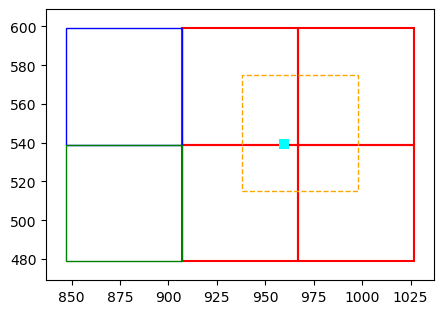

  Stim expansion for shift: [918, 495, 1018, 595]
  Writing lam stim 0: overlap 49, 44
  Writing lam stim 1: overlap 49, 56
  Writing lam stim 2: overlap 51, 56
  Writing lam stim 3: overlap 51, 44
  Adding fixation point
  Shifting stim...
  CROP: New stim size: 60 x 60
  Done


In [5]:
# Set cells-to-analyze and pull best model configuration and mus
Reff = torch.mul(data.robs[:, lam_units], data.dfs[:, lam_units]).numpy()
nspks = np.sum(Reff, axis=0)
a = np.where(nspks > 10)[0]
vallam = lam_units[a]
NCv = len(vallam)
print("%d out of %d units used"%(len(vallam), len(lam_units)))

## CONVERT LLsNULL, which is based on 

# Read in previous data
dirname2 = dirname+'0715/et/'
matdat = sio.loadmat(dirname2+'LLsGLM.mat')
Dreg = matdat['Dreg']
top_cornerUT = matdat['top_corner'][:, 0]

data.set_cells(vallam)

# Load shifts and previous models
dirname2 = dirname+'0715/et/'
SHfile = sio.loadmat( dirname2 + 'BDshifts1.mat' )
fix_n = SHfile['fix_n']
shifts = SHfile['shifts']
metricsLL = SHfile['metricsLL']
metricsTH = SHfile['metricsTH']
ETshifts = SHfile['ETshifts']
ETmetrics = SHfile['ETmetrics']
Ukeeps = SHfile['Ctrain']
XVkeeps = SHfile['Cval']

top_corner_lam = [938, 515]

# Make 60x60 STAs (and GLMs)
Xshift = 0 #8+4 
Yshift = 0 #-10+4
NX = 60

new_tc = np.array([top_corner_lam[0]-Xshift, top_corner_lam[1]-Yshift], dtype=np.int64)
data.draw_stim_locations(top_corner = new_tc, L=NX)

data.assemble_stimulus(top_corner=[new_tc[0], new_tc[1]], L=NX, fixdot=0, shifts=-shifts)


goodfix = np.where(ETmetrics[:,1] < 0.80)[0]
valfix = torch.zeros([ETmetrics.shape[0], 1], dtype=torch.float32)
valfix[goodfix] = 1.0
# Test base-level performance (full DFs and then modify DFs)
#DFsave = deepcopy(data2.dfs)  # this is also in data.dfs
data.dfs_out *= valfix

# STAs

In [6]:
Reff = torch.mul(data.robs[:, vallam], data.dfs[:, vallam])
nspks = torch.sum(Reff, axis=0)
lag = 4
stas0 = ((data.stim[:-lag, ...].T @ Reff[lag:,:]).squeeze() / nspks).reshape([60,60,-1]).numpy()

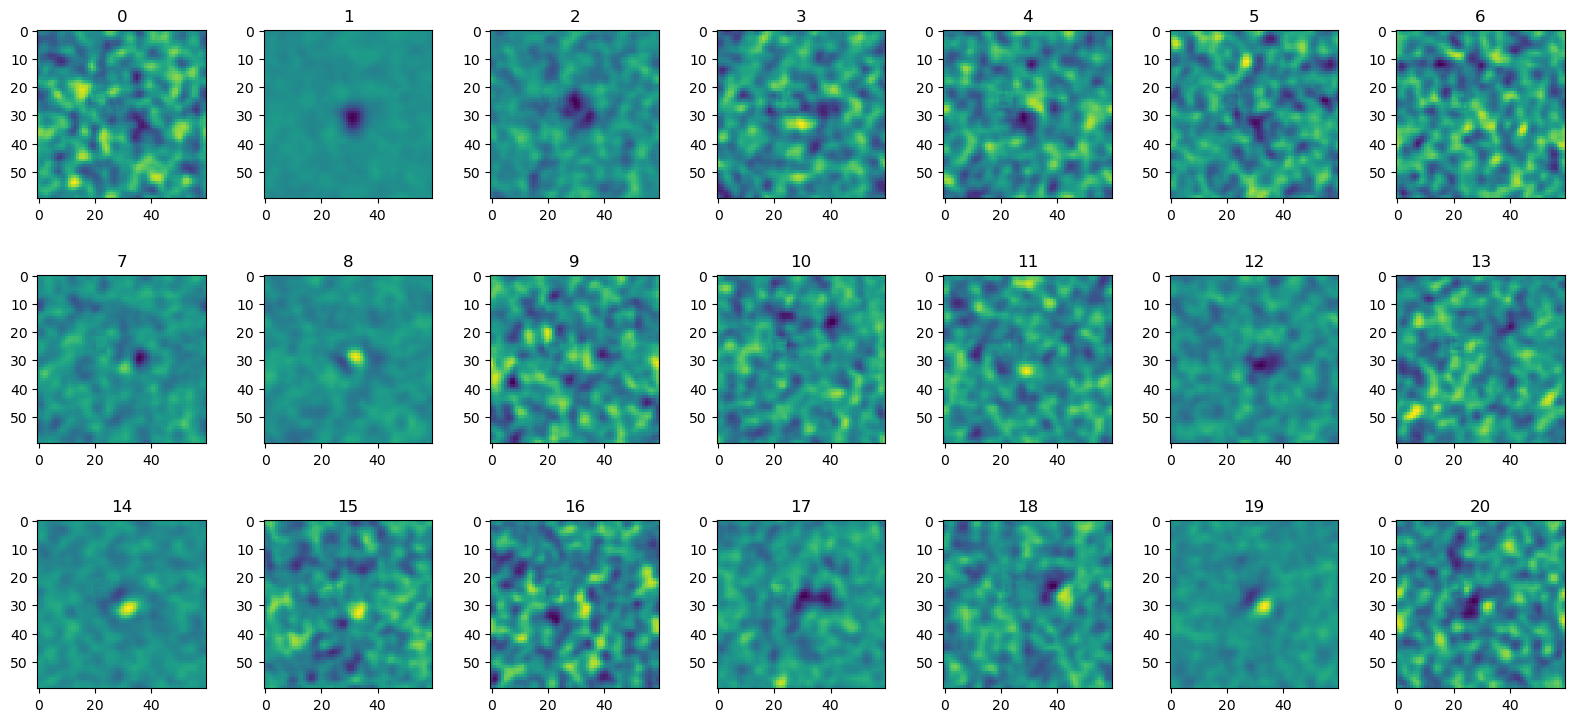

In [7]:
NCv = len(vallam)
ss(3,7)
for cc in range(NCv):
    plt.subplot(3,7, cc+1)
    imagesc(stas0[:,:, cc])
    plt.title(str(cc))
plt.show()

# define drift, GLM, GQM

In [8]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cpu")
dtype = torch.float32

goodfix = np.where(ETmetrics[:,1] < 0.80)[0]
valfix = torch.zeros([ETmetrics.shape[0], 1], dtype=torch.float32)
valfix[goodfix] = 1.0
# Test base-level performance (full DFs and then modify DFs)
#DFsave = deepcopy(data2.dfs)  # this is also in data.dfs
data.dfs_out *= valfix
print("%0.1f%% fixations remaining"%(100*len(goodfix)/ETmetrics.shape[0]))

lbfgs_pars = utils.create_optimizer_params(
    optimizer_type='lbfgs',
    tolerance_change=1e-8,
    tolerance_grad=1e-8,
    history_size=100,
    batch_size=20,
    max_epochs=3,
    max_iter = 500,
    device = device)

adam_parsT = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=5, num_workers=0,
    learning_rate=0.01, early_stopping_patience=10,  # changed from 4
    optimize_graph=False, weight_decay = 0.2)
adam_parsT['device'] = device
adam_parsT['accumulated_grad_batches']=6

68.5% fixations remaining


In [9]:
#set up fits
Treg = 1
Xreg = 20 # [20]
L1reg = 0.1 # [0.5]
GLreg = 10.0 # [4.0]

# drift network
drift_pars1 = NDNLayer.layer_dict(
    input_dims=[1,1,1,NA], num_filters=1, bias=False, norm_type=0, NLtype='lin')
drift_pars1['reg_vals'] = {'d2t': Dreg, 'bcs':{'d2t':0} }
# for stand-alone drift model
drift_pars1N = deepcopy(drift_pars1)
drift_pars1N['NLtype'] = 'softplus'
drift_net =  FFnetwork.ffnet_dict( xstim_n = 'Xdrift', layer_list = [drift_pars1] )

# glm net
glm_layer = Tlayer.layer_dict(
    input_dims=data.stim_dims, num_filters=1, bias=False, num_lags=num_lags,
    NLtype='lin', initialize_center = True)
glm_layer['reg_vals'] = {'d2x': Xreg, 'd2t': Treg, 'l1': L1reg, 'glocalx': GLreg,'edge_t':10}
stim_net =  FFnetwork.ffnet_dict( xstim_n = 'stim', layer_list = [glm_layer] )

# gqm net
num_subs = 2
gqm_layer = Tlayer.layer_dict(
    input_dims=data.stim_dims, num_filters=num_subs, num_inh=0, bias=False, num_lags=num_lags,
    NLtype='square', initialize_center = True)
gqm_layer['reg_vals'] = {'d2x': Xreg, 'd2t': Treg, 'l1': L1reg, 'glocalx': GLreg,'edge_t':10}
stim_qnet =  FFnetwork.ffnet_dict( xstim_n = 'stim', layer_list = [gqm_layer] )

#combine glm
comb_layer = NDNLayer.layer_dict(
    num_filters = 1, NLtype='softplus', bias=False)
comb_layer['weights_initializer'] = 'ones'

net_comb = FFnetwork.ffnet_dict(
    xstim_n = None, ffnet_n=[0,1],
    layer_list = [comb_layer], ffnet_type='add')

#combine gqm
comb2_layer = ChannelLayer.layer_dict(
    num_filters = 1, NLtype='softplus', bias=False)
comb2_layer['weights_initializer'] = 'ones'

net2_comb = FFnetwork.ffnet_dict(
    xstim_n = None, ffnet_n=[0,1,2],
    layer_list = [comb2_layer], ffnet_type='normal')
net2_comb['layer_list'][0]['bias'] = True

glms = [None]*NCv
glm2s = [None]*NCv
gqms = [None]*NCv
driftmods = [None]*NCv
X2opt = np.zeros([NCv,2])
T2opt = np.zeros([NCv,2])
GLopt = np.zeros([NCv,2])
L1opt = np.zeros([NCv,2])
LLsNULL = np.zeros(NCv)
LLsLR = np.zeros([NCv,4])
LLsQR = np.zeros([NCv,4])

rvals = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
rvalsG = [0.001, 0.1, 1, 10, 100, 1000] # glocal
rvalsL = [0.001, 0.01, 0.1, 1] # L1

# fit drift 

In [10]:
for cc in range(NCv):
    # continue if the file already exists
    if os.path.isfile('color_mods/drift_cc'+str(cc)+'.pkl'):
        # load the model and continue
        print('loading model', cc)
        with open('color_mods/drift_cc'+str(cc)+'.pkl', 'rb') as f:
            driftmods[cc] = pickle.load(f)
        continue
    
    data.set_cells([vallam[cc]])
    
    # fit drift network
    drift_iter = NDN.NDN(
        layer_list = [drift_pars1N], loss_type='poisson')
    drift_iter.block_sample=True
    drift_iter.networks[0].xstim_n = 'Xdrift'
    drift_iter.fit( data, force_dict_training=True, train_inds=None, **lbfgs_pars, verbose=0, version=1)
    LLsNULL[cc] = drift_iter.eval_models(data[data.val_blks], null_adjusted=False)[0]

    with open('color_mods/drift_cc'+str(cc)+'.pkl', 'wb') as f:
        pickle.dump(driftmods[cc], f)
    
    driftmods[cc] = deepcopy(drift_iter)

loading model 0


AttributeError: Can't get attribute 'Model' on <module '__main__'>

# plot drift

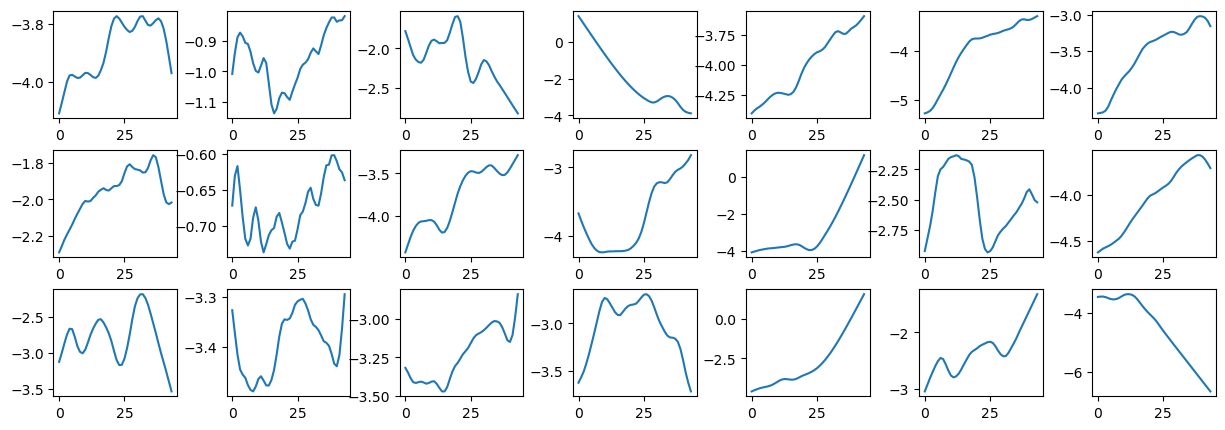

In [13]:
fig = plt.figure(figsize=(15,5))
grid = plt.GridSpec(3, 7, wspace=0.4, hspace=0.3)

for cc in range(NCv):
    row,col = np.unravel_index(cc, (3,7))
    ax = fig.add_subplot(grid[row,col])
    
    w = driftmods[cc].get_weights()
    ax.plot(w)
plt.show()

# fit GLM

In [26]:
for cc in range(NCv):
    # continue if the file already exists
    if os.path.isfile('color_mods/best_GLM_cc'+str(cc)+'.pkl'):
        # load the model and continue
        print('loading model', cc)
        with open('color_mods/best_GLM_cc'+str(cc)+'.pkl', 'rb') as f:
            glms[cc] = pickle.load(f)
        continue

    data.set_cells([vallam[cc]])
    
    best_model = None
    LLs = np.zeros(len(rvals)) + float('inf')
    for rr in range(len(rvals)):
        stim_net['layer_list'][0]['reg_vals']['d2xt'] = rvals[rr]
        glm_iter = NDN.NDN(ffnet_list = [stim_net, drift_net, net_comb], loss_type='poisson')
        glm_iter.block_sample=True
        glm_iter.networks[1].layers[0].weight.data[:,0] = deepcopy(
            driftmods[cc].networks[0].layers[0].weight.data[:,0])
        glm_iter.networks[1].layers[0].set_parameters(val=False)
        glm_iter.networks[2].layers[0].set_parameters(val=False,name='weight')
        
        glm_iter.fit( data, force_dict_training=True, **lbfgs_pars, seed=5, version=9, verbose=0)
        LLi = glm_iter.eval_models(data[data.val_blks], null_adjusted=False)[0]
        if (rr == 0) or (LLi < np.min(LLs)):
            best_model = deepcopy(glm_iter)
        LLs[rr] = LLi
        
    bm0 = np.argmin(LLs)
    LLsLR[cc,0] = LLs[bm0]
    X2opt[cc, 0] = rvals[bm0]
    print( "GLM %3d:  d2xt-R%d   LLs ="%(cc, bm0), LLsNULL[cc]-LLsLR[cc,0] )
    
    LLs = np.zeros(len(rvalsG))+LLsLR[cc,0]
    for rr in range(len(rvalsG)):
        glm_iter = deepcopy(best_model)
        glm_iter.networks[0].layers[0].reg.vals['glocalx'] = rvalsG[rr]
    
        glm_iter.fit( data, force_dict_training=True, **lbfgs_pars, seed=5, verbose=0)
        LLi = glm_iter.eval_models(data[data.val_blks], null_adjusted=False)[0]
        if (LLi < np.min(LLs)):
            best_model = deepcopy(glm_iter)
        LLs[rr] = LLi
    
    bm1 = np.argmin(LLs)
    if LLs[bm1] < LLsLR[cc,0]:
        LLsLR[cc,1] = LLs[bm1]
    else:
        LLsLR[cc,1] = LLsLR[cc,0]
    
    GLopt[cc,0] = rvalsG[bm1]
    #glms[cc] = deepcopy(best_model)
    print( "GLM %3d:  Gloc-R%d   LL = %9.6f ->%9.6f"%(cc, bm1, LLsNULL[cc]-LLsLR[cc,0], LLsNULL[cc]-LLsLR[cc,1]) )
    
    # L1 optimization
    LLs = np.zeros(len(rvalsL))+LLsLR[cc,1]
    for rr in range(len(rvalsL)):
        glm_iter = deepcopy(best_model)
        glm_iter.networks[0].layers[0].reg.vals['l1'] = rvalsL[rr]
        #if bm2>1:
        #glm_iter.networks[0].layers[0].reg.vals['glocalx'] = rvalsG[bm2-1]
        glm_iter.fit( data, force_dict_training=True, **lbfgs_pars, seed=5, verbose=0)
        LLi = glm_iter.eval_models(data[data.val_blks], null_adjusted=False)[0]
        if (LLi < np.min(LLs)):
            best_model = deepcopy(glm_iter)
        LLs[rr] = LLi
    
    bm2 = np.argmin(LLs)
    if LLs[bm2] < LLsLR[cc,1]:
        LLsLR[cc,2] = LLs[bm2]
    else:
        LLsLR[cc,2] = LLsLR[cc,1]
    
    L1opt[cc,0] = rvalsL[bm2]
    
    glms[cc] = deepcopy(best_model)
    
    # save model
    with open('color_mods/best_GLM_cc'+str(cc)+'.pkl', 'wb') as f:
        pickle.dump(glms[cc], f)
    
    print( "GLM %3d:    L1-R%d   LL = %9.6f ->%9.6f"%(cc, bm2, LLsNULL[cc]-LLsLR[cc,1], LLsNULL[cc]-LLsLR[cc,2]) )

Output set to 1 cells
GLM   0:  d2xt-R7   LLs = -0.0025148391723632812
GLM   0:  Gloc-R5   LL = -0.002515 ->-0.000815
GLM   0:    L1-R3   LL = -0.000815 ->-0.000811
Output set to 1 cells
GLM   1:  d2xt-R6   LLs = 0.023921489715576172
GLM   1:  Gloc-R4   LL =  0.023921 -> 0.024290
GLM   1:    L1-R3   LL =  0.024290 -> 0.024293
Output set to 1 cells
GLM   2:  d2xt-R7   LLs = -0.0014901161193847656
GLM   2:  Gloc-R5   LL = -0.001490 -> 0.001587
GLM   2:    L1-R3   LL =  0.001587 -> 0.001587
Output set to 1 cells
GLM   3:  d2xt-R7   LLs = -0.004588603973388672
GLM   3:  Gloc-R5   LL = -0.004589 ->-0.001064
GLM   3:    L1-R3   LL = -0.001064 ->-0.001064
Output set to 1 cells
GLM   4:  d2xt-R6   LLs = 0.005380153656005859
GLM   4:  Gloc-R3   LL =  0.005380 -> 0.005412
GLM   4:    L1-R3   LL =  0.005412 -> 0.005596
Output set to 1 cells
GLM   5:  d2xt-R6   LLs = 0.007918357849121094
GLM   5:  Gloc-R3   LL =  0.007918 -> 0.007934
GLM   5:    L1-R3   LL =  0.007934 -> 0.007946
Output set to 1 c

KeyboardInterrupt: 

# plot GLM

Cell   0: GLM


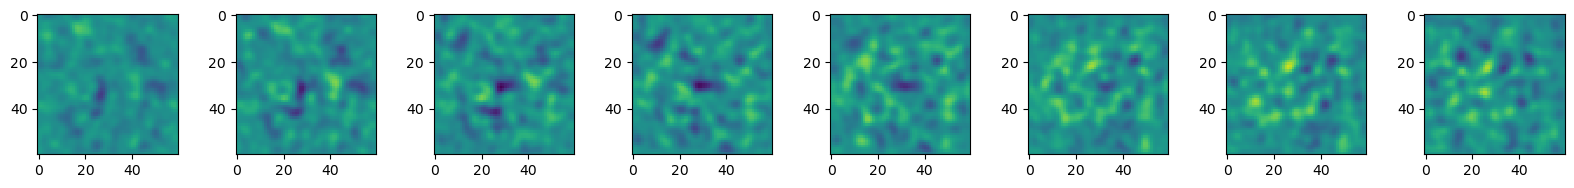

Cell   1: GLM


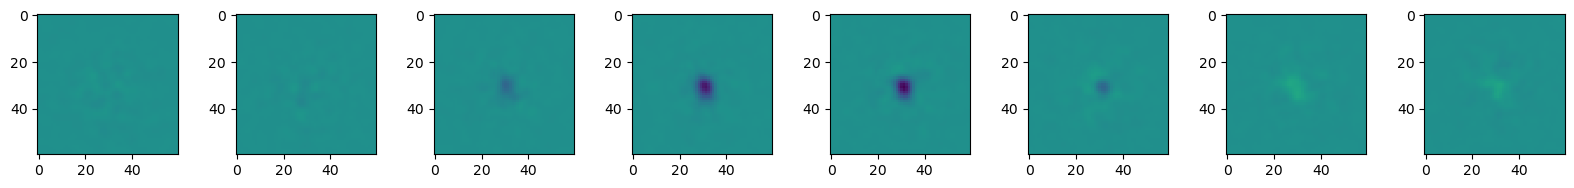

Cell   2: GLM


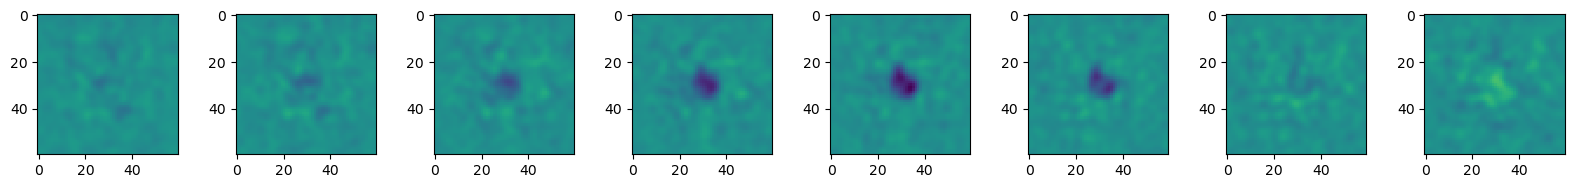

Cell   3: GLM


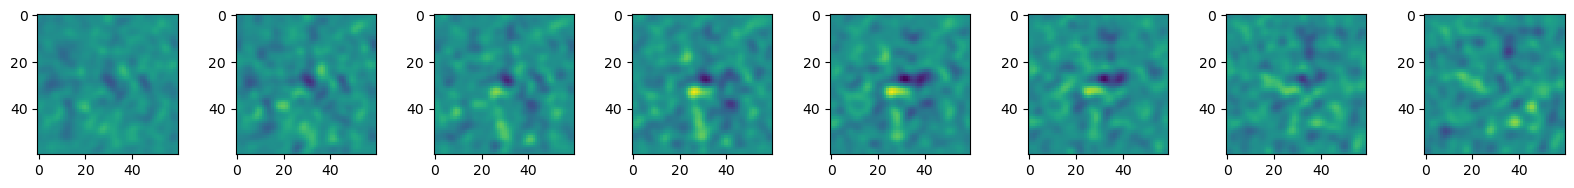

Cell   4: GLM


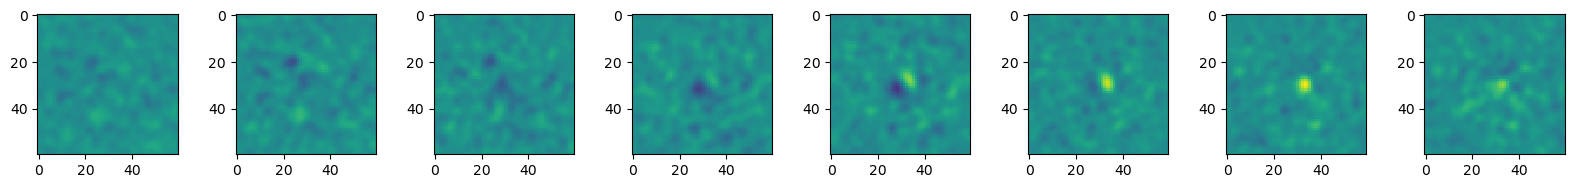

Cell   5: GLM


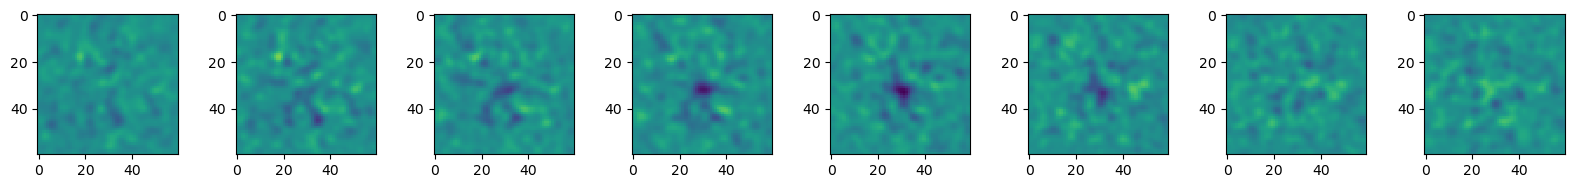

Cell   6: GLM
Cell   7: GLM
Cell   8: GLM
Cell   9: GLM
Cell  10: GLM
Cell  11: GLM
Cell  12: GLM
Cell  13: GLM
Cell  14: GLM
Cell  15: GLM
Cell  16: GLM
Cell  17: GLM
Cell  18: GLM
Cell  19: GLM


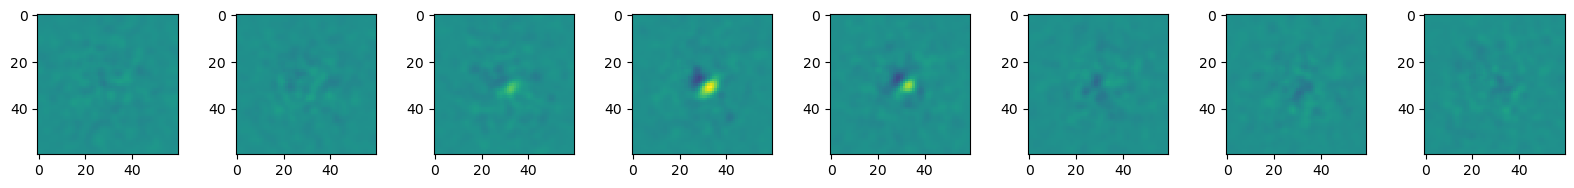

Cell  20: GLM


In [37]:
for cc in range(NCv):
    try:
        print( "Cell %3d: GLM"%(cc) )
        w = glms[cc].get_weights()
        utils.subplot_setup(1,8)
        for ll in range(1,9):
            plt.subplot(1,8,ll)
            utils.imagesc(w[:,:,num_lags-ll,0], aspect=1, max=np.max(abs(w)))
        plt.show()
    except:
        pass

# define GLM2

In [29]:
# GLM2 setup
data.add_covariate('stim2', abs(deepcopy(data.stim)))

In [30]:
data[1].keys()

dict_keys(['stim', 'robs', 'dfs', 'fix_n', 'Xdrift', 'stim2'])

In [31]:
# drift network
drift_pars1 = NDNLayer.layer_dict(
    input_dims=[1,1,1,NA], num_filters=1, bias=False, norm_type=0, NLtype='lin')
drift_pars1['reg_vals'] = {'d2t': Dreg, 'bcs':{'d2t':0} }
# for stand-alone drift model
drift_pars1N = deepcopy(drift_pars1)
drift_pars1N['NLtype'] = 'softplus'
drift_net =  FFnetwork.ffnet_dict( xstim_n = 'Xdrift', layer_list = [drift_pars1] )

# glm net
glm_layer = Tlayer.layer_dict(
    input_dims=data.stim_dims, num_filters=1, bias=False, num_lags=num_lags,
    NLtype='lin', initialize_center = True)
glm_layer['reg_vals'] = {'d2x': Xreg, 'd2t': Treg, 'l1': L1reg, 'glocalx': GLreg,'edge_t':10}
stim_glmnet =  FFnetwork.ffnet_dict( xstim_n = 'stim', layer_list = [glm_layer] )

# glm2 net
glm2_layer = Tlayer.layer_dict(
    input_dims=data.stim_dims, num_filters=1, bias=False, num_lags=num_lags,
    NLtype='lin', initialize_center = True)
glm2_layer['reg_vals'] = {'d2x': Xreg, 'd2t': Treg, 'l1': L1reg, 'glocalx': GLreg,'edge_t':10}
stim_glm2net =  FFnetwork.ffnet_dict( xstim_n = 'stim2', layer_list = [glm2_layer] )

#combine glm
comb2_layer = NDNLayer.layer_dict(
    num_filters = 1, NLtype='softplus', bias=False)
comb2_layer['weights_initializer'] = 'ones'

net_comb2 = FFnetwork.ffnet_dict(
    xstim_n = None, ffnet_n=[0,1,2],
    layer_list = [comb2_layer], ffnet_type='add')


# fit GLM2

In [33]:
for cc in [5]: # NCv
    # continue if the file already exists
    if os.path.isfile('color_mods/best_GLM2_cc'+str(cc)+'.pkl'):
        # load the model and continue
        print('loading model', cc)
        with open('color_mods/best_GLM2_cc'+str(cc)+'.pkl', 'rb') as f:
            glm2s[cc] = pickle.load(f)
        continue

    data.set_cells([vallam[cc]])
    
    # get the best reg_vals for the GLM
    best_reg_vals = glms[cc].networks[0].layers[0].reg.vals

    stim_net['layer_list'][0]['reg_vals'] = deepcopy(best_reg_vals)
    stim_glm2net['layer_list'][0]['reg_vals'] = deepcopy(best_reg_vals)
    glm2 = NDN.NDN(ffnet_list = [stim_net, stim_glm2net, drift_net, net_comb2], loss_type='poisson')
    glm2.block_sample=True
    # initialize with GLM
    glm2.networks[0].layers[0] = deepcopy(glms[cc].networks[0].layers[0])
    # initialize the Drift model
    glm2.networks[2].layers[0].weight.data[:,0] = deepcopy(
        driftmods[cc].networks[0].layers[0].weight.data[:,0])
    glm2.networks[2].layers[0].set_parameters(val=False)
    glm2.networks[3].layers[0].set_parameters(val=False,name='weight')

    glm2.fit( data, force_dict_training=True, **lbfgs_pars, seed=5, version=9, verbose=0)
    LLi = glm2.eval_models(data[data.val_blks], null_adjusted=False)[0]
    best_model = deepcopy(glm2)

    glm2s[cc] = deepcopy(best_model)

    # save the model
    with open('color_mods/best_GLM2_cc'+str(cc)+'.pkl', 'wb') as f:
        pickle.dump(glm2s[cc], f)
    
    print( "GLM2 %3d: LLs ="% cc, LLsNULL[cc]-LLi )

Output set to 1 cells
GLM2   5: LLs = 0.02447986602783203


# plot GLM2

Cell   0: GLM2


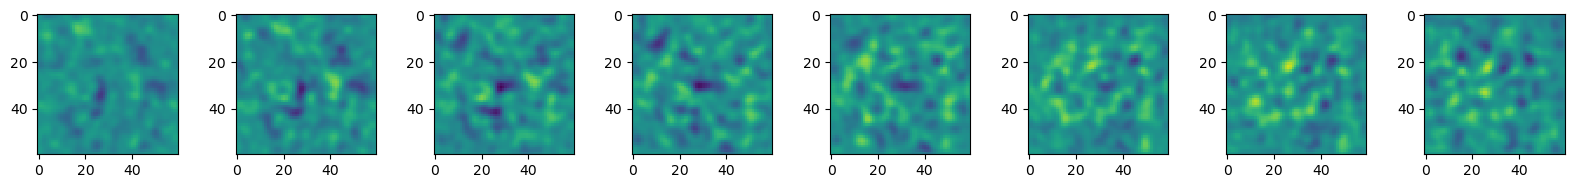

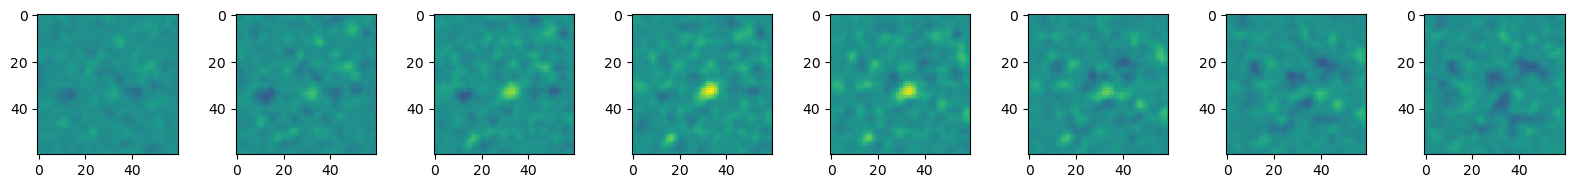

Cell   1: GLM2


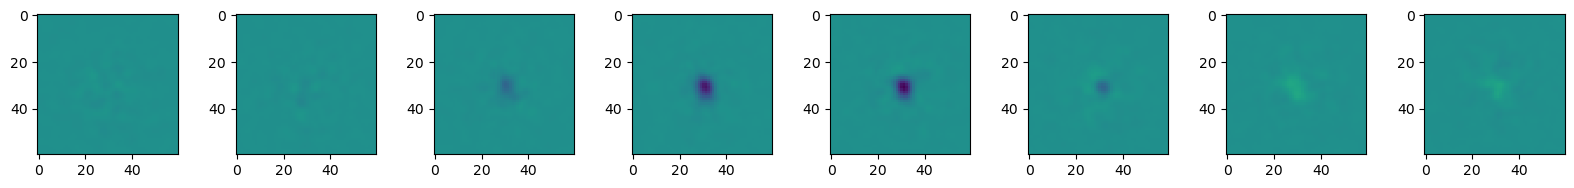

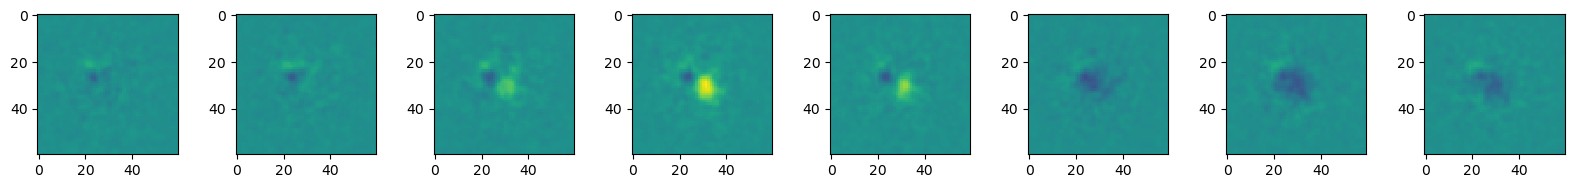

Cell   2: GLM2


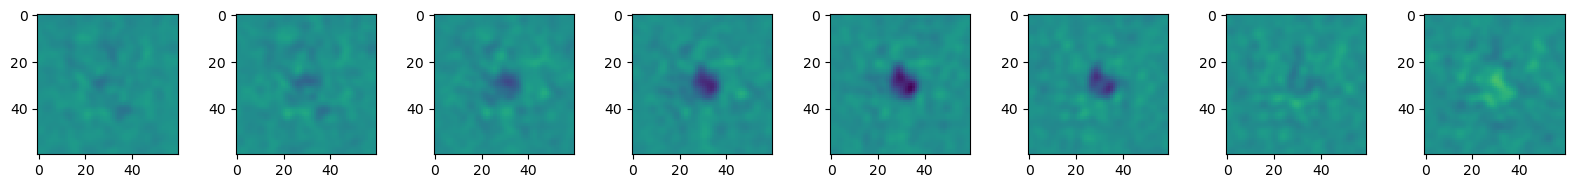

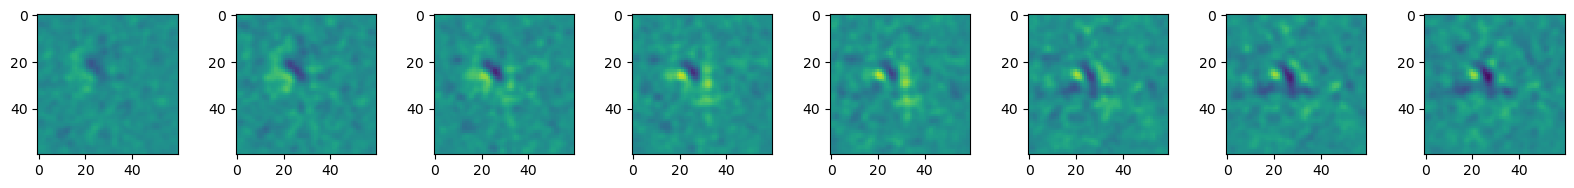

Cell   3: GLM2


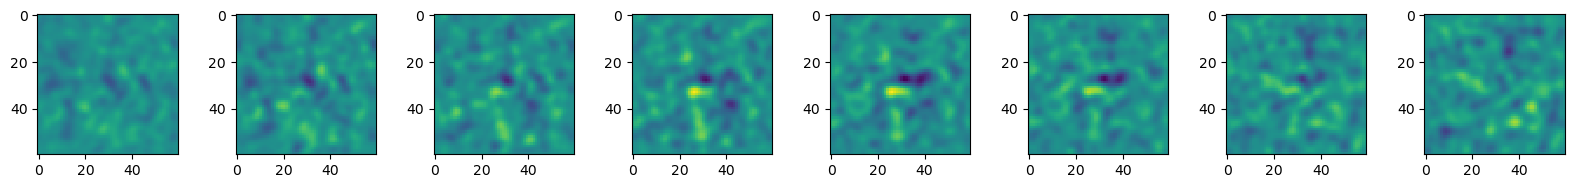

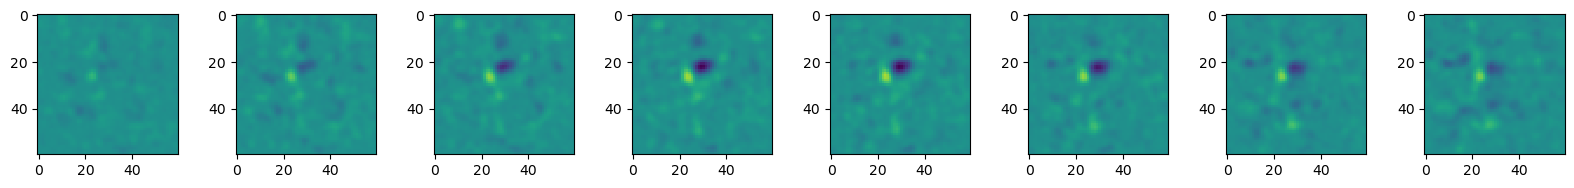

Cell   4: GLM2


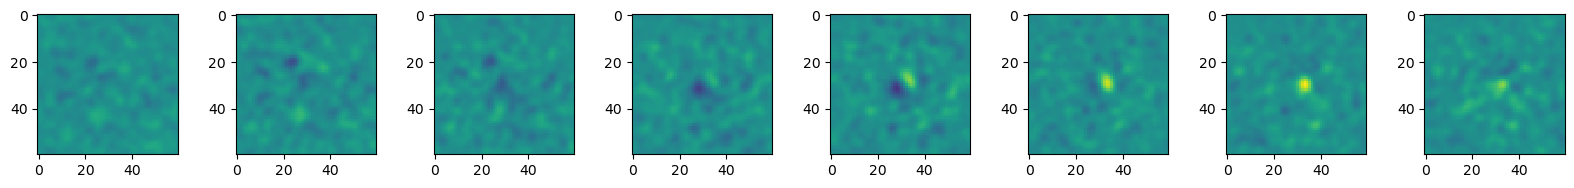

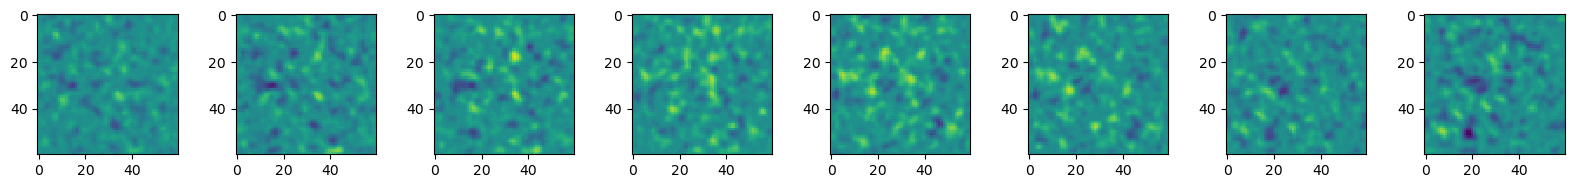

Cell   5: GLM2


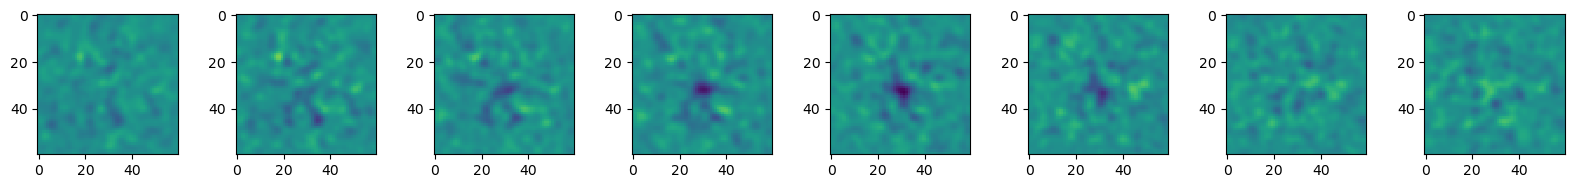

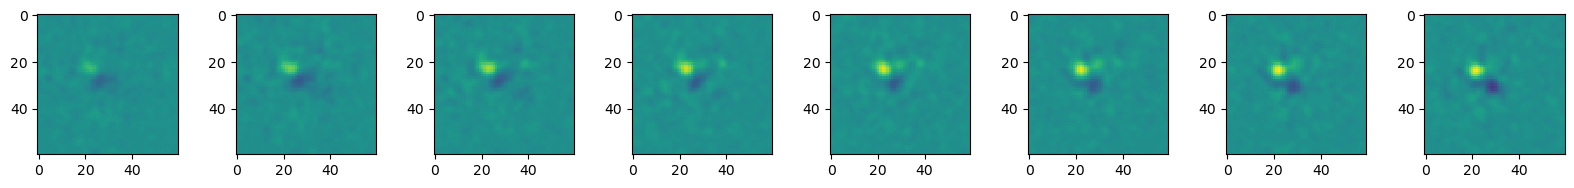

Cell   6: GLM2
Cell   7: GLM2
Cell   8: GLM2
Cell   9: GLM2
Cell  10: GLM2
Cell  11: GLM2
Cell  12: GLM2
Cell  13: GLM2
Cell  14: GLM2
Cell  15: GLM2
Cell  16: GLM2
Cell  17: GLM2
Cell  18: GLM2
Cell  19: GLM2


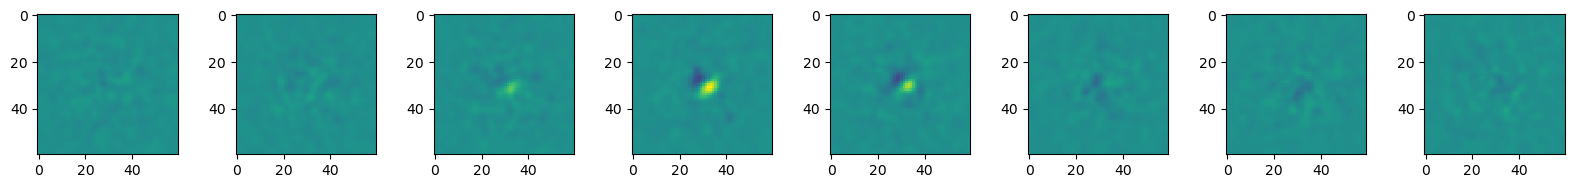

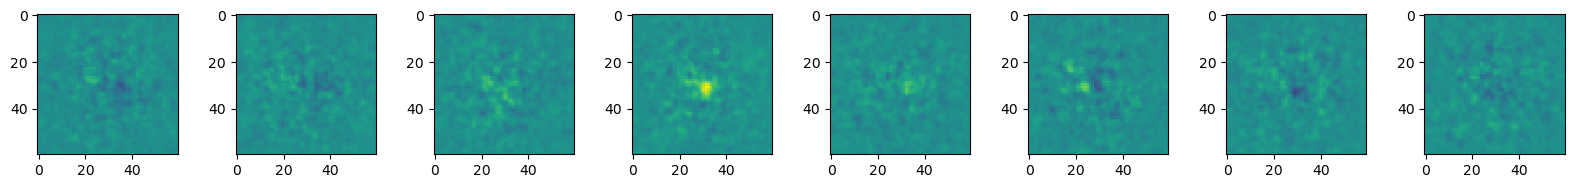

Cell  20: GLM2


In [47]:
for cc in range(NCv):
    try:
        print( "Cell %3d: GLM2"%(cc) )
        w_lin = glm2s[cc].networks[0].layers[0].get_weights()
        w_abs = glm2s[cc].networks[1].layers[0].get_weights()
        utils.subplot_setup(1,8)
        for ll in range(1,9):
            plt.subplot(1,8,ll)
            utils.imagesc(w_lin[:,:,num_lags-ll,0], aspect=1, max=np.max(abs(w_lin)))
        utils.subplot_setup(1,8)
        for ll in range(1,9):
            plt.subplot(1,8,ll)
            utils.imagesc(w_abs[:,:,num_lags-ll,0], aspect=1, max=np.max(abs(w_abs)))
        plt.show()
    except:
        pass

# fit GQM

In [61]:
for cc in range(6): #NCv
    # continue if the file already exists
    if os.path.isfile('color_mods/best_GQM_cc'+str(cc)+'.pkl'):
        # load the model and continue
        print('loading model', cc)
        with open('color_mods/best_GQM_cc'+str(cc)+'.pkl', 'rb') as f:
            gqms[cc] = pickle.load(f)
        continue

    data.set_cells([vallam[cc]])
    
    # now fit GQM
    LLs = np.zeros(len(rvals))+ 1000 #+LLsR[cc,0]
    LLsQR[cc,0] = LLsLR[cc,2]

    # get the best reg_vals for the GLM
    best_reg_vals = glms[cc].networks[0].layers[0].reg.vals
    stim_net['layer_list'][0]['reg_vals'] = deepcopy(best_reg_vals)
    gqm_iter = NDN.NDN(ffnet_list = [stim_net, drift_net, stim_qnet, net2_comb], loss_type='poisson')
    gqm_iter.networks[0].layers[0] = deepcopy(glms[cc].networks[0].layers[0])
    gqm_iter.block_sample=True
    gqm_iter.networks[3].layers[0].set_parameters(val=False,name='weight')
    gqm_iter.networks[1].layers[0].weight.data[:,0] = deepcopy(
        driftmods[cc].networks[0].layers[0].weight.data[:,0])
    gqm_iter.networks[1].layers[0].set_parameters(val=False)
    #gqm_iter.networks[0].layers[0].weight.data[:,0] = deepcopy(best_glm.networks[0].layers[0].weight.data[:,0])

    for rr in range(len(rvalsG)):
        gqm_iter.networks[2].layers[0].reg.vals['glocalx'] = rvalsG[rr]
        gqm_iter.fit( data, force_dict_training=True, **lbfgs_pars, seed=5, version=9, verbose=0)
        LLi = gqm_iter.eval_models(data[data.val_blks], null_adjusted=False)[0]
        if (rr == 0) or (LLi < np.min(LLs)):
            best_model = deepcopy(gqm_iter)
        LLs[rr] = LLi
    
    bmq1 = np.argmin(LLs)
    #if(LLs[bmq1-1]-LLs[bmq1]) < 0.01:
    #    bmq1 += -1
    LLsQR[cc,1] = LLs[bmq1]
    GLopt[cc,1] = rvals[bmq1]
    gqms[cc] = deepcopy(best_model)
    #print(LLs)
    print( "GQM %3d:  Gloc-R%d   LL = %9.6f ->%9.6f"%(cc, bmq1, LLsNULL[cc]-LLsLR[cc,2], LLsNULL[cc]-LLsQR[cc,1]) )
    
    LLs = np.zeros(len(rvals))+LLsQR[cc,1]
    for rr in range(len(rvals)):
        gqm_iter = deepcopy(best_model)
        gqm_iter.networks[2].layers[0].reg.vals['d2xt'] = rvals[rr]
        gqm_iter.fit( data, force_dict_training=True, **lbfgs_pars, seed=5, verbose=0)
        LLi = gqm_iter.eval_models(data[data.val_blks], null_adjusted=False)[0]
        if (LLi < np.min(LLs)):
            best_model = deepcopy(gqm_iter)
        LLs[rr] = LLi
    
    bmq2 = np.argmin(LLs)
    if LLs[bmq2] < LLsQR[cc,1]:
        LLsQR[cc,2] = LLs[bmq2]
    else:
        LLsQR[cc,2] = LLsQR[cc,1]
    
    X2opt[cc,1] = rvals[bmq2]
    #gqms[cc] = deepcopy(best_model)
    #print(LLs)
    print( "GQM %3d:  d2xt-R%d   LL = %9.6f ->%9.6f"%(cc, bmq2, LLsNULL[cc]-LLsQR[cc,1], LLsNULL[cc]-LLsQR[cc,2]) )
    
    LLs = np.zeros(len(rvalsL))+LLsQR[cc,2]
    for rr in range(len(rvalsL)):
        gqm_iter = deepcopy(best_model)
        gqm_iter.networks[2].layers[0].reg.vals['l1'] = rvalsL[rr]
        gqm_iter.fit( data, force_dict_training=True, **lbfgs_pars, seed=5, verbose=0)
        LLi = gqm_iter.eval_models(data[data.val_blks], null_adjusted=False)[0]
        if (LLi < np.min(LLs)):
            best_model = deepcopy(gqm_iter)
        LLs[rr] = LLi
    
    bmq3 = np.argmin(LLs)
    if LLs[bmq3] < LLsQR[cc,2]:
        LLsQR[cc,3] = LLs[bmq3]
    else:
        LLsQR[cc,3] = LLsQR[cc,2]
    
    L1opt[cc,1] = rvalsL[bmq3]
    
    gqms[cc] = deepcopy(best_model)

    # save the model
    with open('color_mods/best_GQM_cc'+str(cc)+'.pkl', 'wb') as f:
        pickle.dump(gqms[cc], f)
    
    print( "GQM %3d:    L1-R%d   LL = %9.6f ->%9.6f"%(cc, bmq3, LLsNULL[cc]-LLsQR[cc,2], LLsNULL[cc]-LLsQR[cc,3]) )

loading model 0
loading model 1
loading model 2
loading model 3
loading model 4
loading model 5


# plot GQM

Cell   0: GQM
(60, 60, 12, 1) (60, 60, 12, 2)


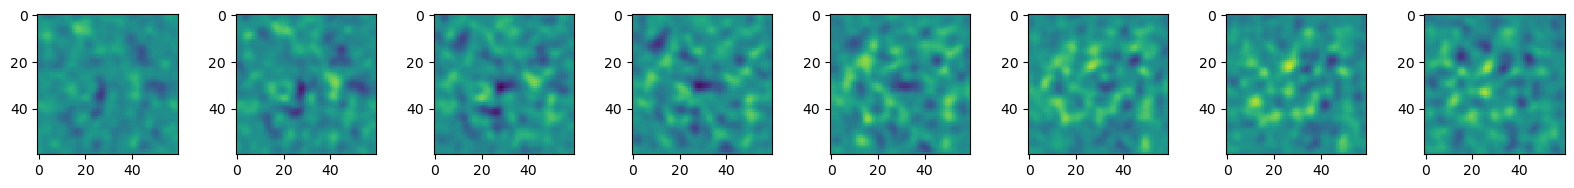

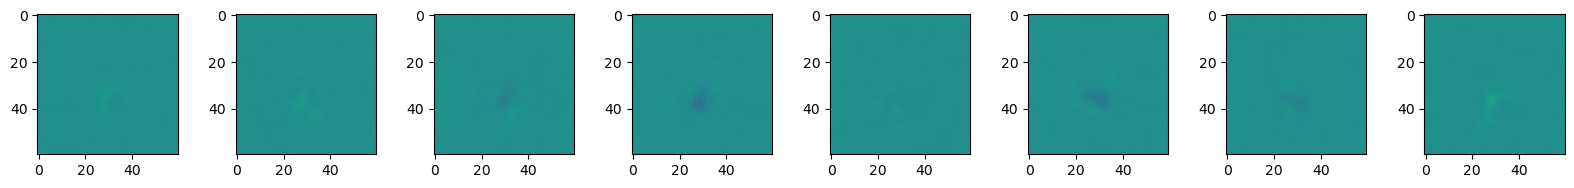

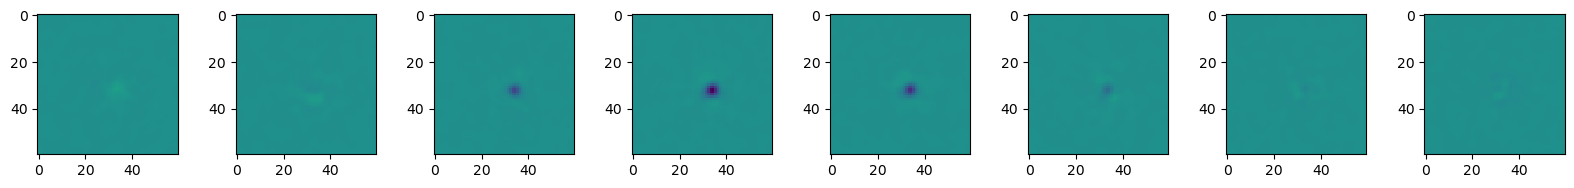

Cell   1: GQM
(60, 60, 12, 1) (60, 60, 12, 2)


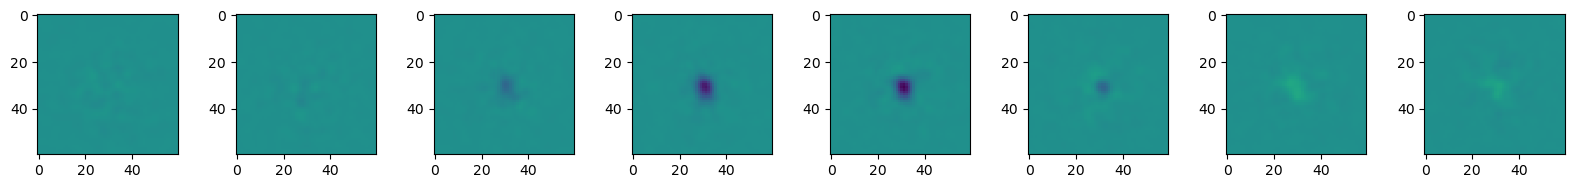

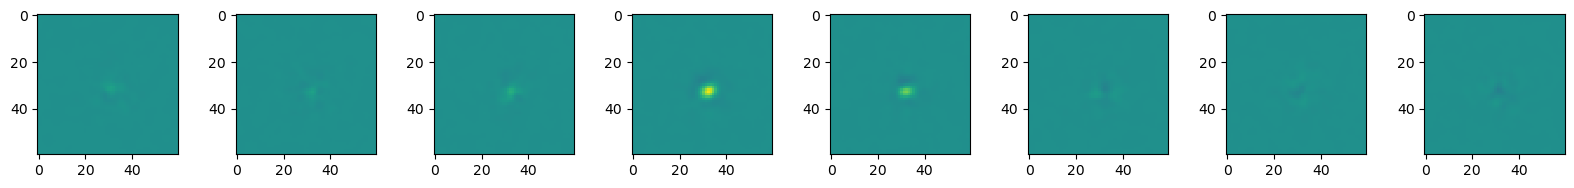

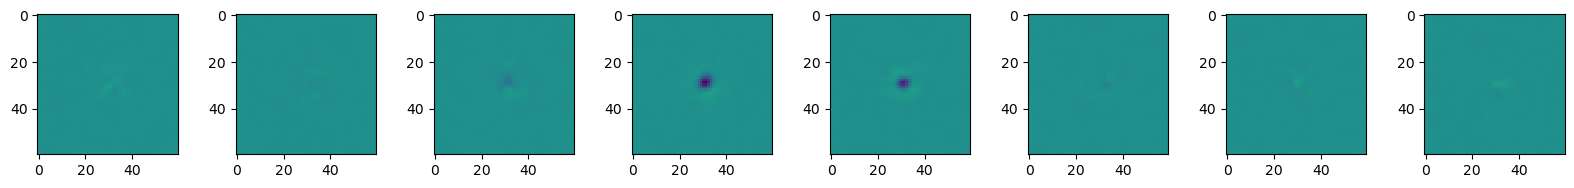

Cell   2: GQM
(60, 60, 12, 1) (60, 60, 12, 2)


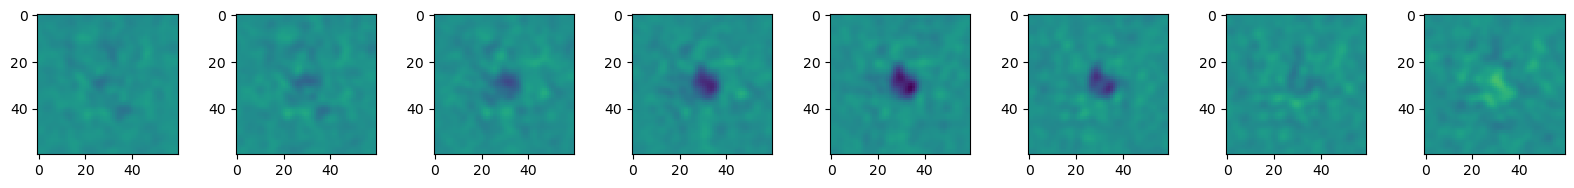

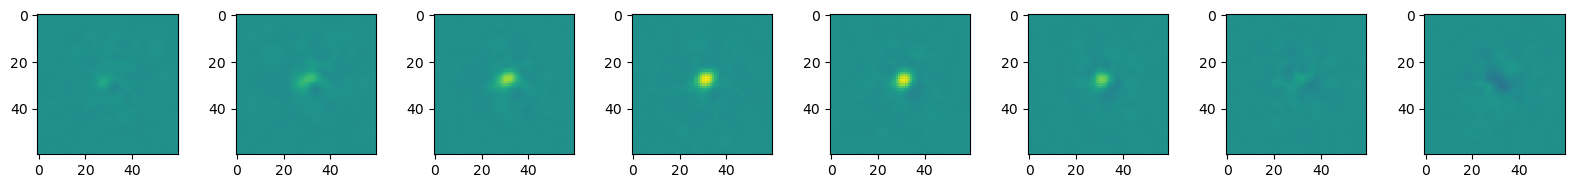

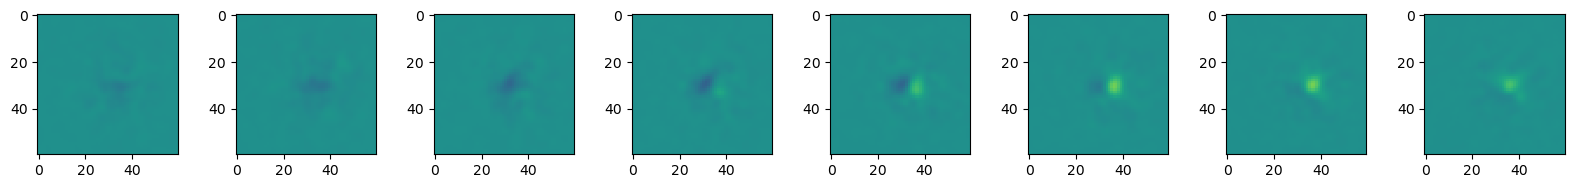

Cell   3: GQM
(60, 60, 12, 1) (60, 60, 12, 2)


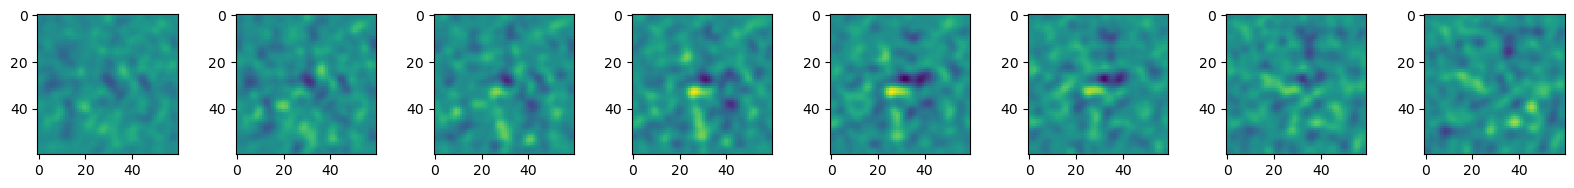

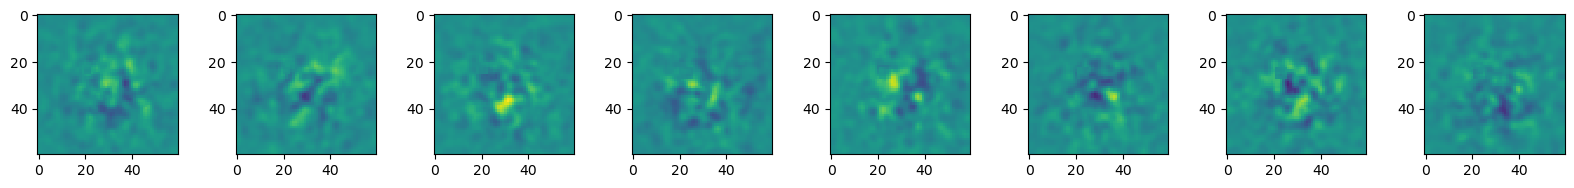

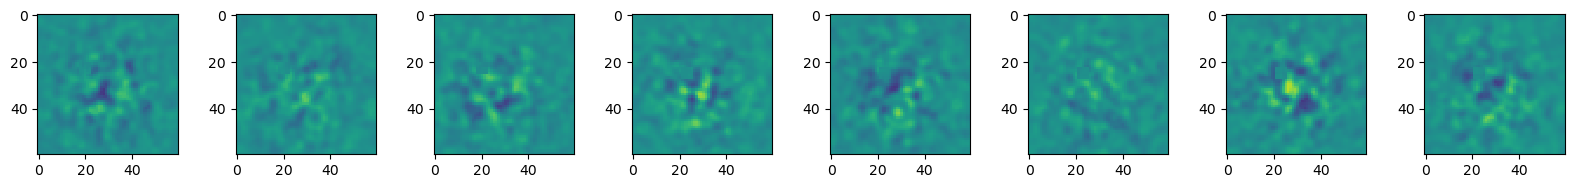

Cell   4: GQM
(60, 60, 12, 1) (60, 60, 12, 2)


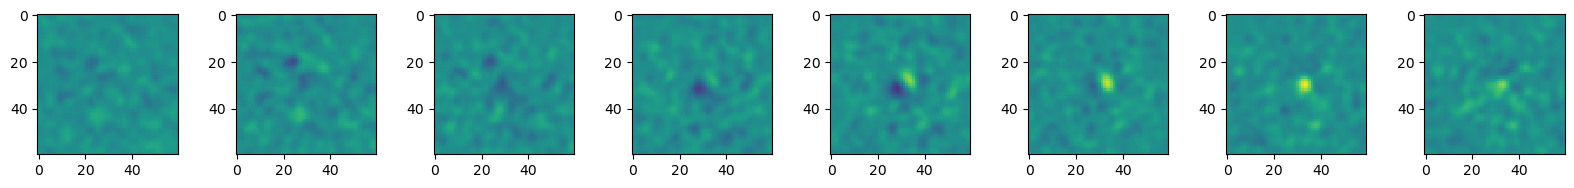

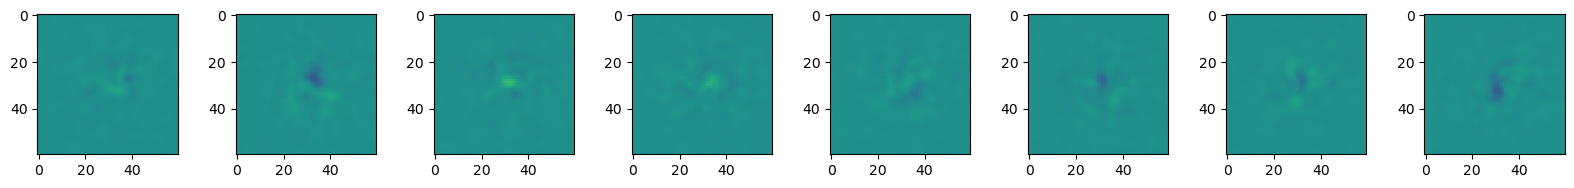

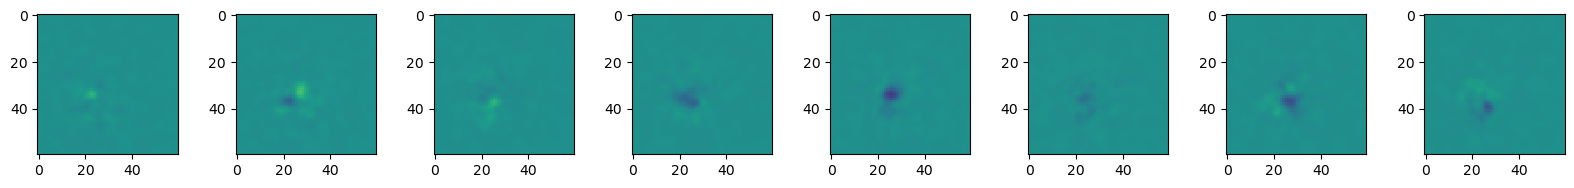

Cell   5: GQM
(60, 60, 12, 1) (60, 60, 12, 2)


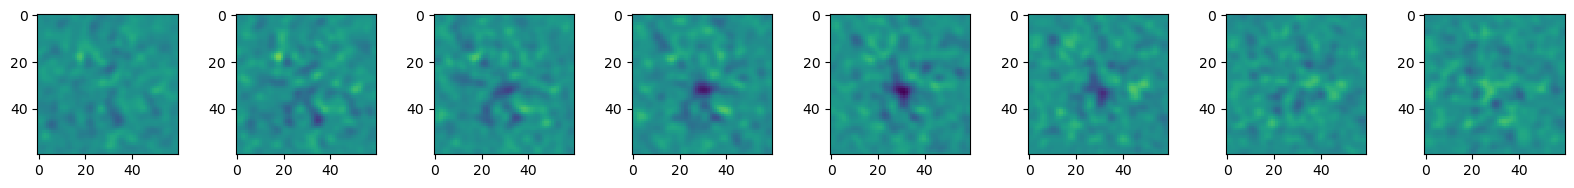

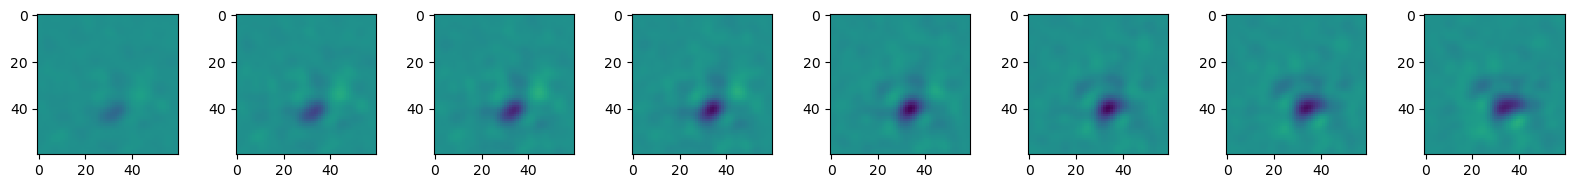

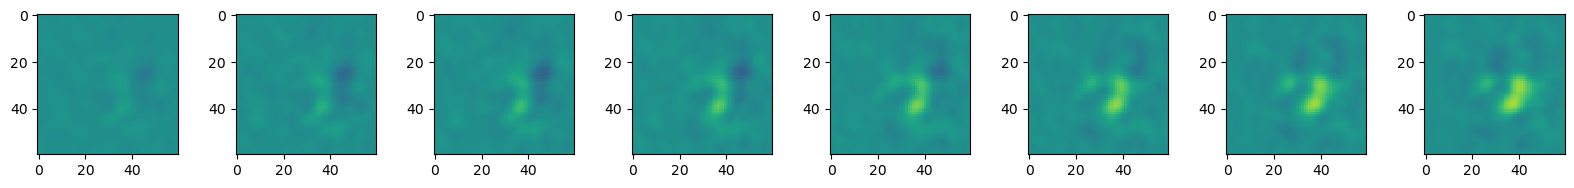

Cell   6: GQM
Cell   7: GQM
Cell   8: GQM
Cell   9: GQM
Cell  10: GQM
Cell  11: GQM
Cell  12: GQM
Cell  13: GQM
Cell  14: GQM
Cell  15: GQM
Cell  16: GQM
Cell  17: GQM
Cell  18: GQM
Cell  19: GQM
(60, 60, 12, 1) (60, 60, 12, 2)


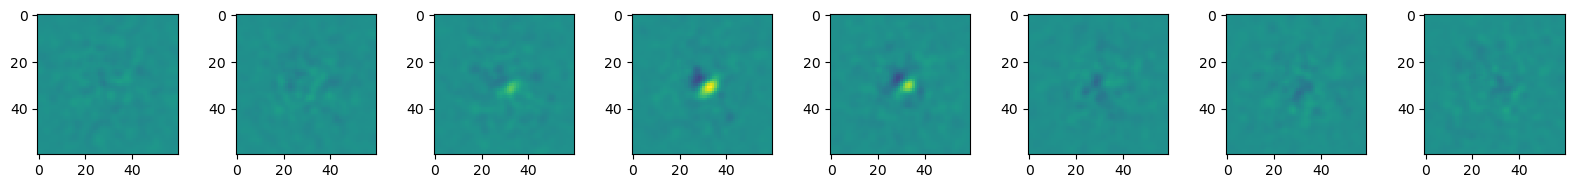

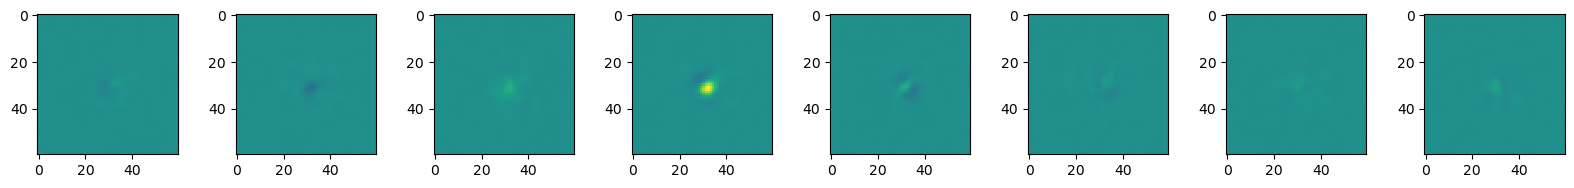

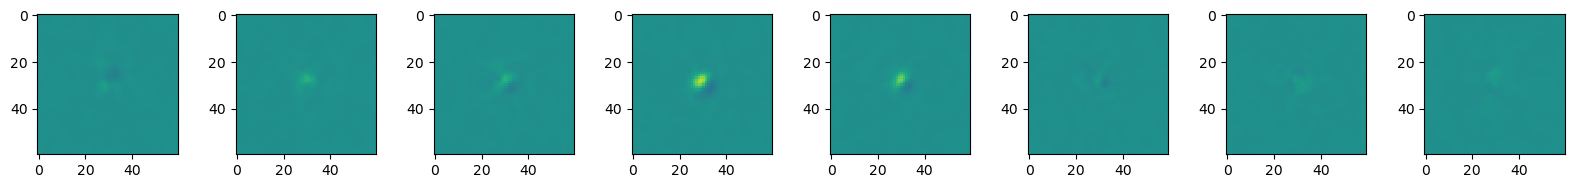

Cell  20: GQM


In [45]:
for cc in range(NCv):
    try:
        print( "Cell %3d: GQM"%(cc) )
        w_lin = gqms[cc].networks[0].layers[0].get_weights()
        w_quad = gqms[cc].networks[2].layers[0].get_weights()
        print(w_lin.shape, w_quad.shape)
        utils.subplot_setup(1,8)
        for ll in range(1,9):
            plt.subplot(1,8,ll)
            utils.imagesc(w_lin[:,:,num_lags-ll,0], aspect=1, max=np.max(abs(w_lin)))
        utils.subplot_setup(1,8)
        for ll in range(1,9):
            plt.subplot(1,8,ll)
            utils.imagesc(w_quad[:,:,num_lags-ll,0], aspect=1, max=np.max(abs(w_quad)))
        utils.subplot_setup(1,8)
        for ll in range(1,9):
            plt.subplot(1,8,ll)
            utils.imagesc(w_quad[:,:,num_lags-ll,1], aspect=1, max=np.max(abs(w_quad)))
        plt.show()
    except:
        pass

# simple vs. complex

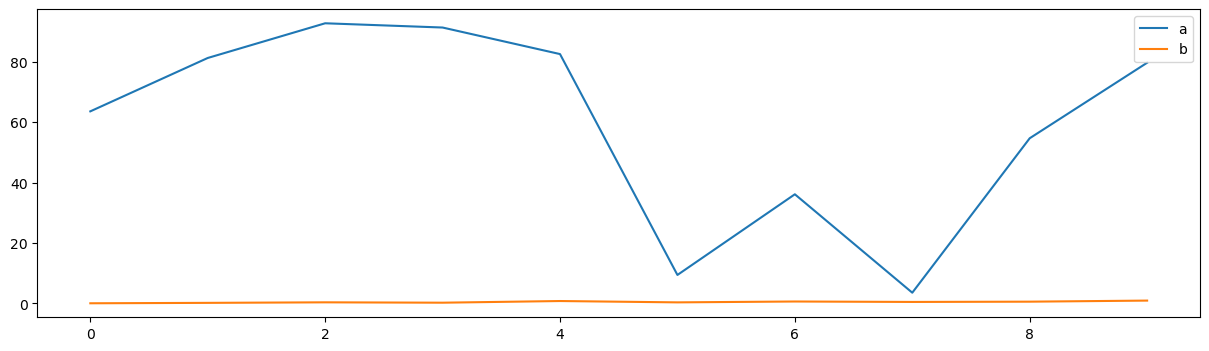

In [59]:
fig = plt.figure(figsize=(15,4))
a = np.random.random(10)*100
b = np.random.random(10)

plt.plot(a, label='a')
plt.plot(b, label='b')
plt.legend()
plt.show()

In [66]:
# correlation between and b
np.corrcoef(a,b)[0,1], np.corrcoef(a,a)[0,1], np.corrcoef(a,a*1000)[0,1]

(-0.017332650476886088, 1.0, 0.9999999999999998)

In [81]:
# look at activations in simple and complex part of model (GLM2 and GQM)
# correlated with the robs for that cell

len(data.block_inds), data.robs.shape
data.dfs.shape, data.val_inds

(torch.Size([167520, 239]),
 array([   480,    481,    482, ..., 167517, 167518, 167519]))

0
Linear Correlation 59.65084
Quadratic Correlation 56.36845
Complex Score 0.4858541171544026


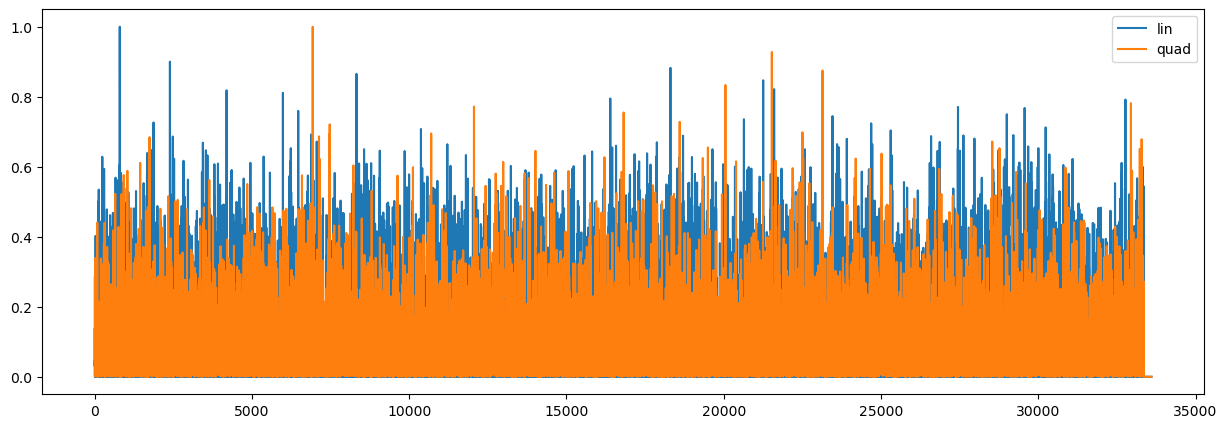

1
Linear Correlation 1474.3345
Quadratic Correlation 1173.1753
Complex Score 0.4431240663211671


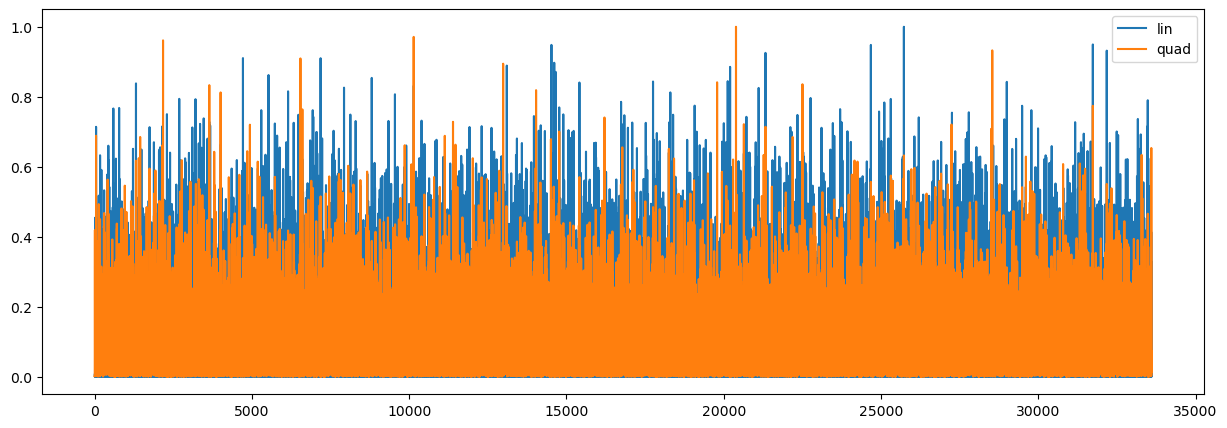

2
Linear Correlation 315.94843
Quadratic Correlation 233.26747
Complex Score 0.4247281856821969


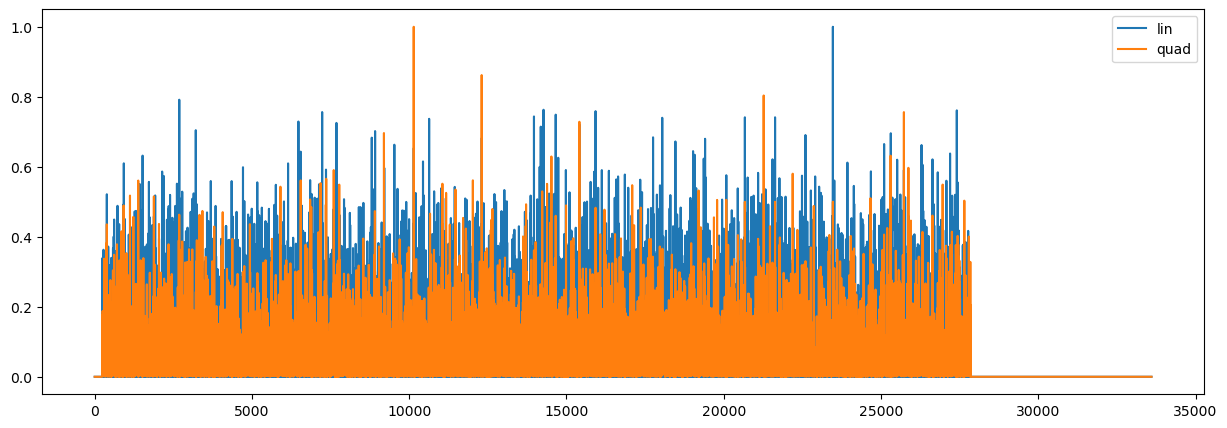

3
Linear Correlation 48.93151
Quadratic Correlation 16.378553
Complex Score 0.25078146166427234


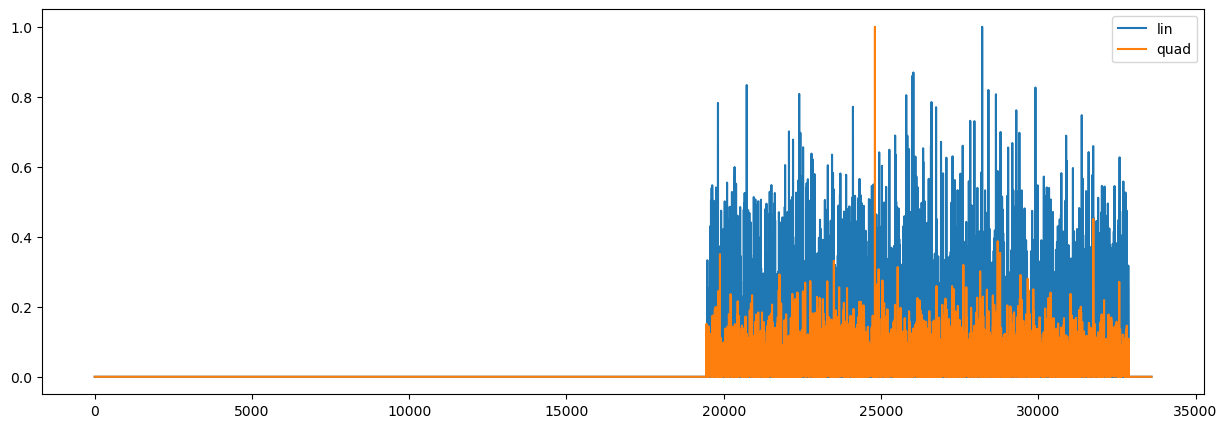

4
Linear Correlation 68.002686
Quadratic Correlation 39.939873
Complex Score 0.37001043309464415


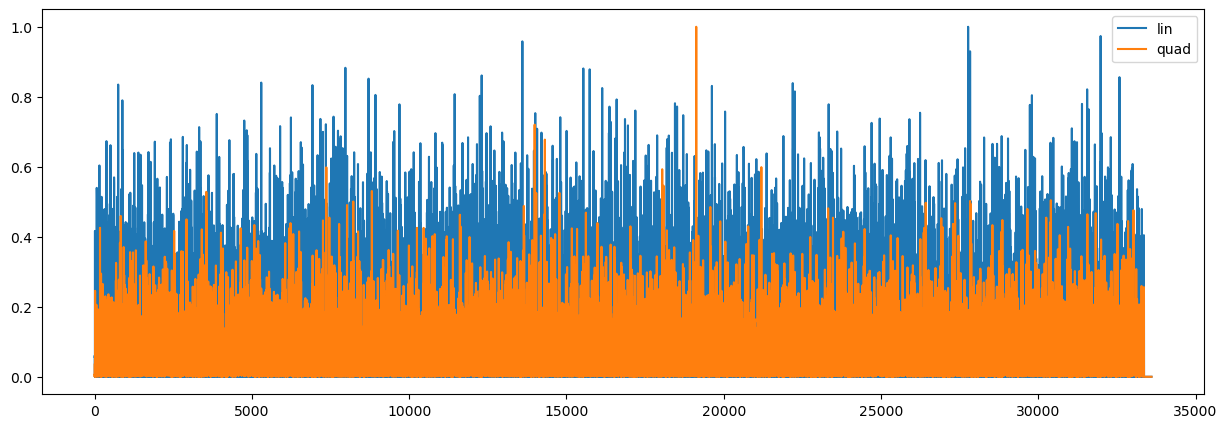

5
Linear Correlation 82.483444
Quadratic Correlation 52.67666
Complex Score 0.3897352659688113


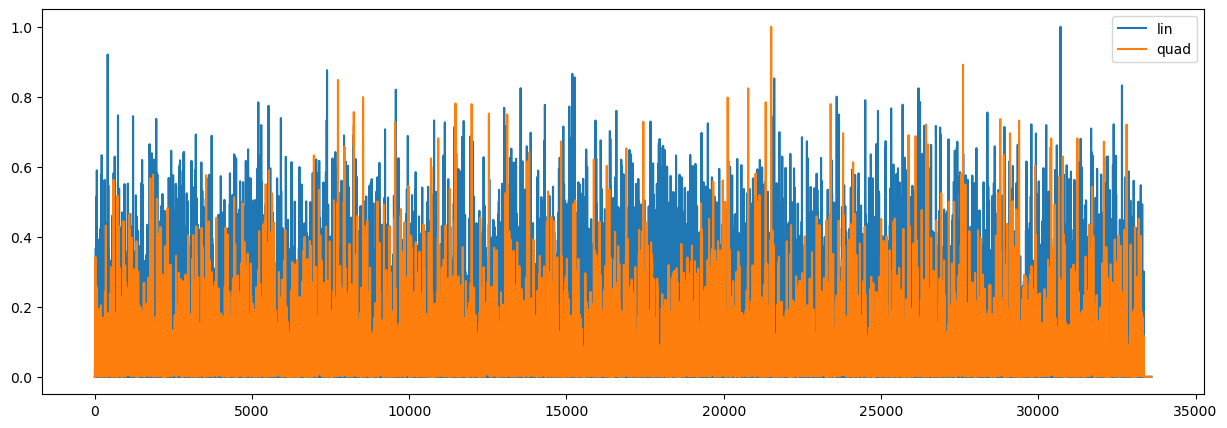

In [75]:
dfs = data.dfs.detach().numpy()

trial = 0
for cc in [0,1,2,3,4,5]:
    print(cc)
    z_lin = gqms[cc].networks[0].layers[0](data.stim[data.val_inds,:]) # lin
    z_lin = z_lin.cpu().detach().numpy().squeeze()*dfs[data.val_inds,vallam[cc]]
    z_quad = gqms[cc].networks[2].layers[0](data.stim[data.val_inds,:]) # quad
    z_quad = np.sum(z_quad.cpu().detach().numpy(), axis=1)*dfs[data.val_inds, vallam[cc]]
    robs = data.robs[data.val_inds,vallam[cc]]*dfs[data.val_inds,vallam[cc]]
    robs = robs.detach().numpy()
    
    # rectify the linear
    z_lin = np.where(z_lin < 0, 0, z_lin)
    
    # min-max scale the activations
    z_lin = (z_lin - np.min(z_lin)) / (np.max(z_lin) - np.min(z_lin))
    z_quad = (z_quad - np.min(z_quad)) / (np.max(z_quad) - np.min(z_quad))
    
    fig = plt.figure(figsize=(15,5))
    plt.plot(z_lin, label='lin')
    plt.plot(z_quad, label='quad')
    #plt.plot(robs, label='robs')
    
    # correlation between robs and z_lin and z_quad
    lin_corr = np.correlate(robs, z_lin)[0]
    quad_corr = np.correlate(robs, z_quad)[0]
    
    rect_lin_corr = 0 if lin_corr < 0 else lin_corr
    rect_quad_corr = 0 if quad_corr < 0 else quad_corr
    complex_score = rect_quad_corr / sum([rect_lin_corr, rect_quad_corr])
    
    print('Linear Correlation', lin_corr)
    print('Quadratic Correlation', quad_corr)
    print('Complex Score', complex_score)
    
    plt.legend()
    plt.show()

# test optimizer

In [23]:
# glm net
cc = 0
data.set_cells([vallam[cc]])

glm_layer = Tlayer.layer_dict(
    input_dims=data.stim_dims, num_filters=1, bias=False, num_lags=num_lags,
    NLtype='lin', initialize_center = True)
glm_layer['reg_vals'] = {'d2x': Xreg, 'd2t': Treg, 'l1': L1reg, 'glocalx': GLreg,'edge_t':10}
stim_net =  FFnetwork.ffnet_dict( xstim_n = 'stim', layer_list = [glm_layer] )

glm = NDN.NDN(ffnet_list = [stim_net, drift_net, net_comb], loss_type='poisson')
glm.block_sample = True

glm.networks[1].layers[0].weight.data[:,0] = deepcopy(
    driftmods[cc].networks[0].layers[0].weight.data[:,0])
glm.networks[1].layers[0].set_parameters(val=False)
glm.networks[2].layers[0].set_parameters(val=False,name='weight')

glm.fit( data, force_dict_training=True, **lbfgs_pars, seed=5, version=9, verbose=0)
LLi = glm.eval_models(data[data.val_blks], null_adjusted=False)[0]
print(LLsNULL[cc] - LLi)

Output set to 1 cells
-0.012475013732910156


In [24]:
from NDNT.utils.training_utils import HPTuner, ParameterType, Parameters

parameters = Parameters()
parameters.add('d2xt', ParameterType.float, start=0.01, end=10000.0)
parameters.add('glocalx', ParameterType.float, start=0.001, end=1000.0)
parameters.add('l1', ParameterType.float, start=0.001, end=1.0)
for param in parameters:
    print(param)

hptuner = HPTuner(parameters, lr=0.01, num_init=2, num_iter=10)
hyperparams = hptuner.initial_hyperparams()
print(hyperparams)

Parameter(name=d2xt, type=ParameterType.float, start=0.01, end=10000.0)
Parameter(name=glocalx, type=ParameterType.float, start=0.001, end=1000.0)
Parameter(name=l1, type=ParameterType.float, start=0.001, end=1.0)
{'d2xt': 2219.939490965684, 'glocalx': 870.7324354450702, 'l1': 0.207512436184087}


In [25]:
while not hptuner.is_finished():
    glm_layer['reg_vals']['d2xt'] = hyperparams['d2xt']
    glm_layer['reg_vals']['glocalx'] = hyperparams['glocalx']
    glm_layer['reg_vals']['l1'] = hyperparams['l1']
    stim_net =  FFnetwork.ffnet_dict( xstim_n = 'stim', layer_list = [glm_layer] )
    
    glm = NDN.NDN(ffnet_list = [stim_net, drift_net, net_comb], loss_type='poisson')
    glm.block_sample = True
    
    glm.networks[1].layers[0].weight.data[:,0] = deepcopy(
        driftmods[cc].networks[0].layers[0].weight.data[:,0])
    glm.networks[1].layers[0].set_parameters(val=False)
    glm.networks[2].layers[0].set_parameters(val=False,name='weight')
    
    glm.fit( data, force_dict_training=True, **lbfgs_pars, seed=5, version=9, verbose=0)
    LLi = glm.eval_models(data[data.val_blks], null_adjusted=False)[0]
    null_adjusted_LL = LLsNULL[cc] - LLi
    
    print(hyperparams, null_adjusted_LL)
    
    hyperparams = hptuner.step(null_adjusted_LL)

{'d2xt': 2219.939490965684, 'glocalx': 870.7324354450702, 'l1': 0.207512436184087} -0.001277923583984375
{'d2xt': 9186.109893270137, 'glocalx': 488.4117003836403, 'l1': 0.6121321190397431} -0.0011782646179199219
{'d2xt': 3770.183165970263, 'glocalx': 821.4498031955766, 'l1': 0.29130227504090844} -0.0012311935424804688


/home/mattjac/anaconda3/envs/pytorch2/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


{'d2xt': 3836.778290269362, 'glocalx': 820.5379881467164, 'l1': 0.2938128285981818} -0.0012292861938476562
{'d2xt': 3766.3817489247353, 'glocalx': 821.310715723109, 'l1': 0.29115507525771483} -0.001232147216796875
{'d2xt': 3766.381739826945, 'glocalx': 821.3107155566724, 'l1': 0.29115507508157096} -0.001232147216796875
{'d2xt': 3766.3817489247353, 'glocalx': 821.310715723109, 'l1': 0.29115507525771483} -0.001232147216796875
{'d2xt': 4098.031689888687, 'glocalx': 831.6107823686305, 'l1': 0.3525210143776689} -0.0011992454528808594


/home/mattjac/anaconda3/envs/pytorch2/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


{'d2xt': 3766.3819831134856, 'glocalx': 821.3107028702486, 'l1': 0.29115506165520844} -0.001232147216796875


/home/mattjac/anaconda3/envs/pytorch2/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


{'d2xt': 3768.9160269550766, 'glocalx': 821.7279781405115, 'l1': 0.29071347590813434} -0.0012311935424804688


KeyboardInterrupt: 

In [32]:
# try hyperopt
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

# define the function we want to minimise
def objective(params):
    glm_layer['reg_vals']['d2xt'] = params['d2xt']
    glm_layer['reg_vals']['glocalx'] = params['glocalx']
    glm_layer['reg_vals']['l1'] = params['l1']
    stim_net =  FFnetwork.ffnet_dict( xstim_n = 'stim', layer_list = [glm_layer] )

    glm = NDN.NDN(ffnet_list = [stim_net, drift_net, net_comb], loss_type='poisson')
    glm.block_sample = True

    glm.networks[1].layers[0].weight.data[:,0] = deepcopy(
        driftmods[cc].networks[0].layers[0].weight.data[:,0])
    glm.networks[1].layers[0].set_parameters(val=False)
    glm.networks[2].layers[0].set_parameters(val=False,name='weight')

    glm.fit( data, force_dict_training=True, **lbfgs_pars, seed=5, version=9, verbose=0)
    LLi = glm.eval_models(data[data.val_blks], null_adjusted=False)[0]
    null_adjusted_LL = LLsNULL[cc] - LLi

    return {'loss': -1 * null_adjusted_LL, 'status': STATUS_OK}

In [33]:
# parameters.add('d2xt', ParameterType.float, start=0.01, end=10000.0)
# parameters.add('glocalx', ParameterType.float, start=0.001, end=1000.0)
# parameters.add('l1', ParameterType.float, start=0.001, end=1.0)
params = {'d2xt': hp.uniform('d2xt', 0.01, 10000.0),
          'glocalx': hp.uniform('glocalx', 0.001, 1000.0),
          'l1': hp.uniform('l1', 0.001, 1.0)}
algorithm = tpe.suggest

In [34]:
# implement Hyperopt
best_params = fmin(
    fn=objective,
    space=params,
    algo=algorithm,
    max_evals=10)

100%|██████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:43<00:00,  4.39s/trial, best loss: 0.0010104179382324219]


In [ ]:
from utils.hptuning import * 

hptuner = HPTuner()
hptuner.add('d2xt', hp.uniform('d2xt', 0.01, 10000.0))
hptuner.add('glocalx', hp.uniform('glocalx', 0.001, 1000.0))
hptuner.add('l1', hp.uniform('l1', 0.001, 1.0))

best_params = hptuner.tune(objective, max_evals=10)

{'name': 'float', 'pos_args': [<hyperopt.pyll.base.Apply object at 0x7f416063dd90>], 'named_args': [], 'o_len': None, 'pure': True, 'define_params': None}


TypeError: require string label

In [47]:
import optuna

def objective(trial):
    # define the function we want to minimise
    glm_layer['reg_vals']['d2xt'] = trial.suggest_float('d2xt', 0.01, 10000.0)
    glm_layer['reg_vals']['glocalx'] = trial.suggest_float('glocalx', 0.001, 1000.0)
    glm_layer['reg_vals']['l1'] = trial.suggest_float('l1', 0.001, 1.0)
    
    stim_net =  FFnetwork.ffnet_dict( xstim_n = 'stim', layer_list = [glm_layer] )

    glm = NDN.NDN(ffnet_list = [stim_net, drift_net, net_comb], loss_type='poisson')
    glm.block_sample = True

    glm.networks[1].layers[0].weight.data[:,0] = deepcopy(
        driftmods[cc].networks[0].layers[0].weight.data[:,0])
    glm.networks[1].layers[0].set_parameters(val=False)
    glm.networks[2].layers[0].set_parameters(val=False,name='weight')

    glm.fit( data, force_dict_training=True, **lbfgs_pars, seed=5, version=9, verbose=0)
    LLi = glm.eval_models(data[data.val_blks], null_adjusted=False)[0]
    null_adjusted_LL = LLsNULL[cc] - LLi

    return null_adjusted_LL

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

study.best_params

[I 2023-06-30 16:21:01,127] A new study created in memory with name: no-name-af59570c-696b-46ce-93da-9c07286699a8
[I 2023-06-30 16:21:05,055] Trial 0 finished with value: -0.0012807846069335938 and parameters: {'d2xt': 2015.2845169233144, 'glocalx': 848.5789248697406, 'l1': 0.29713777395345453}. Best is trial 0 with value: -0.0012807846069335938.
[I 2023-06-30 16:21:09,504] Trial 1 finished with value: -0.0013685226440429688 and parameters: {'d2xt': 4701.372199474365, 'glocalx': 451.4567091688192, 'l1': 0.618977259113915}. Best is trial 0 with value: -0.0012807846069335938.
[I 2023-06-30 16:21:13,287] Trial 2 finished with value: -0.0013995170593261719 and parameters: {'d2xt': 1843.8775658775057, 'glocalx': 675.2509992062651, 'l1': 0.33435568656331294}. Best is trial 0 with value: -0.0012807846069335938.
[I 2023-06-30 16:21:17,171] Trial 3 finished with value: -0.0024018287658691406 and parameters: {'d2xt': 2610.506554345336, 'glocalx': 174.7884496881804, 'l1': 0.09042076127132154}. Be

{'d2xt': 3031.5260469571,
 'glocalx': 975.0985694228989,
 'l1': 0.07591066328283386}

{'loss': 0.0010104179382324219, 'status': 'ok'}

# fit my model

In [ ]:
trainer_params = r.TrainerParams(num_lags=num_lags,
                                 device="cuda:1", # use the second GPU
                                 max_epochs=1,
                                 batch_size=20,
                                 history_size=100,
                                 max_iter=100,
                                 init_num_samples=9,
                                 bayes_num_steps=10,
                                 num_initializations=1,
                                 block_sample=True,
                                 trainer_type=r.TrainerType.lbfgs)

In [ ]:
# load drift model
drift_weights = []
for cc in range(0, len(vallam)):
    e = exp.load('color_drift_cc' + str(cc), experiment_location='../experiments')
    drift_weights.append(e.trials[0].model.NDN.networks[0].layers[0].weight)

#plt.imshow(np.array(drift_weights).squeeze())

In [ ]:
drift_weights[0]

In [ ]:
#for cc in range(0, len(vallam)):

cc = 0

drift_dims = [1, 1, 1, data.Xdrift.shape[1]]
inp_drift = m.Input(covariate='Xdrift', input_dims=drift_dims)

inp_glm = m.Input(covariate='stim', input_dims=data.stim_dims)

drift2_layer = m.Layer(
    weights=drift_weights[cc],
    freeze_weights=True,
    NLtype=m.NL.linear,
    num_filters=1,
    bias=False,
    reg_vals={'d2t': r.Sample(default=Dreg, typ=r.RandomType.float, values=[Dreg], start=0.00001, end=0.1),
              'bcs': {'d2t': 0}})
drift2_net = m.Network(layers=[drift2_layer],
                      name='drift')

glm_layer = m.TemporalLayer(
    NLtype=m.NL.linear,
    num_filters=1,
    bias=False,
    initialize_center=True,
    num_lags=num_lags,
    reg_vals={
              'd2xt': r.Sample(default=0.001, typ=r.RandomType.float, values=[0.001], start=0.0001, end=1000.0),
              'd2x': r.Sample(default=20, typ=r.RandomType.int, values=[20], start=10, end=30),
              'd2t': r.Sample(default=1, typ=r.RandomType.int, values=[1], start=1, end=4),
              'l1': r.Sample(default=0.1, typ=r.RandomType.float, values=[0.1], start=0.001, end=1.0),
              'glocalx': r.Sample(default=10.0, typ=r.RandomType.float, values=[10.0], start=5.0, end=1000.0),
              'edge_t': r.Sample(default=10, typ=r.RandomType.int, values=[10], start=5, end=15)})
glm_net = m.Network(layers=[glm_layer],
                    name='glm')

inp_drift.to(drift2_net)
inp_glm.to(glm_net)
output_glm = m.Output(num_neurons=1)
m.Add(networks=[drift2_net, glm_net], NLtype=m.NL.softplus).to(output_glm)

glm_model = m.Model(output_glm,
                    name='GLM',
                    create_NDN=False, verbose=True)

# set the cells to a single cell
data.set_cells([vallam[cc]])

runner = r.Runner(experiment_name='color_glm_cc' + str(cc),
                  dataset_expt=[fn], # name of the experiment
                  dataset=data,
                  dataset_on_gpu=False,
                  model_template=glm_model,
                  trainer_params=trainer_params,
                  overwrite=False,
                  trial_params={})
runner.run()

In [ ]:
e = exp.load('color_glm_cc0', experiment_location='../experiments')
e.trials_df